In [0]:
#import librari yang diperlukan

import numpy as np
import pandas as pd
from levy import get_levy_flight_array
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [0]:
#===========================initiate data ================================
file_input = 'USDJPYterbaru'
choose_column = 'close'
percentage_train = 0.8
percentage_validate = 0.2
#=========================================================================

#import data dari file csv
data = pd.read_csv(file_input+'.csv',header=None)
data.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
shape = data.shape
length_data = shape[0]

display(data.head())
data = data['close']

#membagi data menjadi data training dan data testing
data_train = data[:round(length_data*percentage_train)]
data_validate = data[round(length_data*percentage_train):]
data_test = data_validate.reset_index(drop=True)

,date,time,open,high,low,close,volume
0,2003.09.26,00:00,112.07,112.33,111.65,111.68,9297
1,2003.09.29,00:00,111.61,111.82,110.69,110.80,10488
2,2003.09.30,00:00,110.80,112.14,110.09,111.49,13151
3,2003.10.01,00:00,111.47,111.60,110.50,110.60,9832
4,2003.10.02,00:00,110.59,111.45,110.51,110.75,9362


In [0]:
#======================hyper  parameter=========================
window = 5

#50, 100, 150
popsize = 150 

#:0.3 ; 0.5; 0.8
switch_prob = 0.8

max_iter = 100
#================================================================

In [0]:
#fungsi membuat tabel yang berisi data sliding window
def sliding_window(data, window=5):
    data_window = []
    for i in range(len(data)-window):
        sub_data = []
        for j in range(window):
            sub_data.append(data[i+j])
        data_window.append(sub_data)
    df = pd.DataFrame(data_window)
    return df

In [0]:
#memisahkan data target
data_window = sliding_window(data_train,window=window+1)
train_x = data_window.drop(window,axis=1) #window days before value
train_y = data_window[window] #days value

In [0]:
#fungsi inisialisasi populasi
def initialize_population(popsize,window=5):
    return np.array([[np.random.uniform(0, 1) for i in range(window+1)] for j in range(popsize)])

#fungsi menghitung MSE individu
def mse_ind(individu,x,y,window=5):
    return np.mean((np.sum(individu[0:window]*x,axis=1)+individu[window]-y)**2)

#fungsi menghitung MSE populasi (semua individu)
def mse_all(population, window, data_x, data_y):
    counter = 0
    solution = []
    for individu in population:
        solution.append([counter,individu,mse_ind(individu,data_x,data_y, window=window)])
        counter += 1
    return solution

#melakukan penyerbukan global
def global_pol(gbest,flower,window=5):
    levy_vector = get_levy_flight_array(window+1)
    new_flower = flower + levy_vector*(gbest[1]-flower)
    return new_flower

#melakukan penyerbukan lokal
def local_pol(flower,window=5):
    flower1 = np.random.randint(0,len(population))
    flower2 = np.random.randint(0,len(population))
    new_flower = flower + np.random.uniform(0,1,window+1)*(population[flower1]-population[flower2])
    return new_flower

#fungsi penyerbukan
def polination(gbest,population,switch_prob,window):
    new_pop = []
    for individu in population:
        rand = np.random.uniform(0,1)
        if rand < switch_prob:
            #global polination
            new_pop.append(global_pol(gbest,individu, window=window))
        else:
            #local politantion
            new_pop.append(local_pol(individu,window=window))
    return np.array(new_pop)

# Flower Polination Algorithm Forecasting with Multiple Linier Regression and Evaluation with Mean Squared Error

In [0]:
#membuatt populasi
population = initialize_population(popsize, window)

#menghitung nilai fitness
fitness_all = mse_all(population, window, train_x, train_y)

#menyimpan individu terbaik sementara
gbest = min(fitness_all, key = lambda x:x[2])

#menjalankan algoritma penyerbukan bunga
solution = []
for i in range(max_iter):
    #membuat populasi
    new_pop = polination(gbest,population,switch_prob,window)
    #menghitung fitness
    fitness_all = mse_all(new_pop, window, train_x, train_y)
    
    #mencari individu terbaik dari populasi yang ada
    pop_gbest = min(fitness_all, key = lambda x:x[2])

    #membandingkan individu terbaik sementara dengan individu terbaik populasi
    if pop_gbest[2] < gbest[2]:
        gbest = pop_gbest
    population = new_pop
    solution.append([i+1,gbest[2]])

#menyimpan data ke dalam file
solution_df = pd.DataFrame(solution,columns=['iteration','MSE'])
save_file = file_input+'_'+str(switch_prob)+'_'+str(popsize)
solution_df.to_csv(save_file+'.csv')
fo = open(save_file+'.txt','w+')
for i in range(len(gbest[1])):
    if i != len(gbest[1])-1:
        fo.write('x'+str(i+1)+' '+str(gbest[1][i])+'\n')
    else:
        fo.write('bias'+' '+str(gbest[1][i]))
fo.close()

## Plotting MSE each Iteration

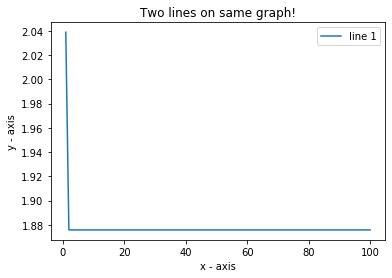

In [0]:
data_plot = pd.read_csv('USDJPYterbaru_0.3_50.csv')

#membuat grafik perubahan individu terbaik
# line 1 points 
x1 = data_plot['iteration']
y1 = data_plot['MSE']
# plotting the line 1 points  
plt.plot(x1, y1, label = "line 1") 
  
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
# giving a title to my graph 
plt.title('Two lines on same graph!') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

## Plotting result prediction (validate)

In [0]:
#memisahkan data target dengan dataset data testing
data_window = sliding_window(data_test,window=window+1)
test_x = data_window.drop(window,axis=1) #window days before value
test_y = data_window[window] #days value

In [0]:
#membuat objek linear regresi
regressor = LinearRegression()
regressor.fit(test_x, test_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#menggunakan nilai kromosom individu sebagai koefisien linear regeresi
regressor.coef_ = gbest[1][:5]

In [0]:
#melakukan regresi pada data testing
y_pred = regressor.predict(test_x)

In [0]:
#membuat tabel hasil regresi
result = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred+gbest[1][5:]})

#mencari mean squared error dari hasil prediksi
paramM_mse = mean_squared_error(result['Actual'], result['Predicted'])
result

,Actual,Predicted
0,99.558,99.375722
1,100.356,100.185374
2,99.865,100.563050
3,99.534,100.046675
4,99.234,99.991603
...,...,...
634,112.894,113.615369
635,112.092,113.749135
636,112.159,112.794479
637,112.977,113.027126


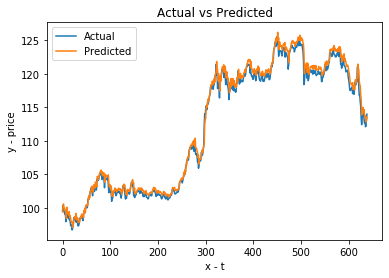

===========================================Summary==============================================
Data "USDJPY"

Mean Squared Error =  0.7243353920068822

sliding window =  5 ; + bias

coefficient =  [ 0.07727768  0.02929574  0.24208967 -0.23813027  0.90573746 -1.67319024]

column choose =  close

data split : train percentage =  0.8 ; test percentage =  0.2

popsize =  150 ; switch probability (p) =  0.8 ; maximum iteration =  100


In [0]:
result_plot = result

#grafik hasil sebenarnya
# line 1 points 
x1 = result_plot.index.values
y1 = result_plot['Actual']
# plotting the line 1 points  
plt.plot(x1, y1, label = "Actual") 
  
#grafik hasil prediksi
# line 2 points 
x2 = result_plot.index.values
y2 = result_plot['Predicted']
# plotting the line 2 points  
plt.plot(x2, y2, label = "Predicted") 
  
# naming the x axis 
plt.xlabel('x - t') 
# naming the y axis 
plt.ylabel('y - price') 
# giving a title to my graph 
plt.title('Actual vs Predicted') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

print('===========================================Summary==============================================')
print('Data "USDJPY"')
print()
print('Mean Squared Error = ',mean_squared_error(result['Actual'], result['Predicted']))
print()
print('sliding window = ', window,'; + bias')
print()
print('coefficient = ',gbest[1])
print()
print('column choose = ',choose_column)
print()
print('data split : train percentage = ', percentage_train, '; test percentage = ', percentage_validate)
print()
print('popsize = ', popsize, '; switch probability (p) = ', switch_prob, '; maximum iteration = ', max_iter)
print('================================================================================================')